In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

%matplotlib inline

In [2]:
# Load data into train and test dataframes
train_data = pd.read_csv(
    r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\sberbank_russian_housing_market\house-prices-advanced-regression-techniques\train.csv'
    )
test_data = pd.read_csv(
    r'CourseMaterials/Data/sberbank_russian_housing_market/house-prices-advanced-regression-techniques/test.csv'
    )

In [3]:
# Split data into X and y after dropping rows with missing target (SalePrice)
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
X = train_data.drop(['SalePrice'], axis=1)
y = train_data.SalePrice

In [4]:
# Find numeric and categorical columns and store in separate lists
numeric_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']

In [5]:
# For categorical columns, keep only those with cardinality < 10:
# cardinality = number of unique values in a column
low_cardinality_cols = [col for col in categorical_cols if X[col].nunique() < 10]
high_cardinality_cols = list(set(categorical_cols) - set(low_cardinality_cols))

# Count number of unique entries in each column with categorical data
object_nunique = list(map(lambda col: X[col].nunique(), categorical_cols))
object_nunique = pd.Series(object_nunique, index=categorical_cols).sort_values()

# Number of unique entries for last 3 columns (above 10 unique entries each)
print(object_nunique.tail(3))

# Drop categorical columns with high cardinality
X.drop(high_cardinality_cols, axis=1, inplace=True)

Exterior1st     15
Exterior2nd     16
Neighborhood    25
dtype: int64


In [11]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('cat', categorical_transformer, low_cardinality_cols)
    ])

In [15]:
# Define a function to measure quality of each approach for a random forest model
def get_score(X, y, cv, n_estimators):
    """Return the average MAE over provided CV folds of random forest model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    cv -- number of folds in cross-validation
    """
    data_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators, random_state=0))
    ])
    scores = -1 * cross_val_score(estimator=data_pipeline, X=X, y=y, cv=cv, scoring='neg_mean_absolute_error')
    return scores.mean()

In [16]:
results_n_estimators = {forest_size: get_score(X, y, 3, forest_size) for forest_size in range(50, 450, 50)}

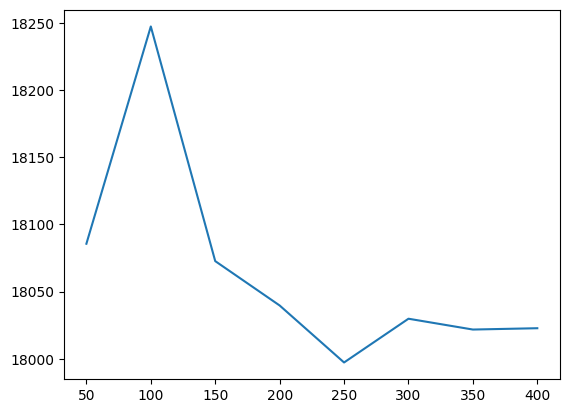

In [17]:
plt.plot(list(results_n_estimators.keys()), list(results_n_estimators.values()))
plt.show()

In [19]:
n_estimators_best = min(results_n_estimators, key=results_n_estimators.get)
print(n_estimators_best)

250


In [24]:
results_cv = {cv: get_score(X, y, cv, n_estimators_best) for cv in range(2, 11)}

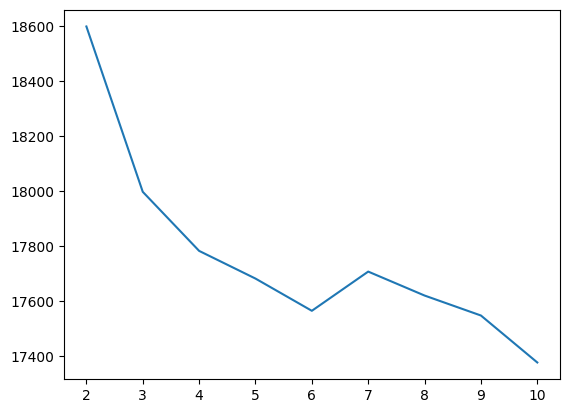

In [25]:
plt.plot(list(results_cv.keys()), list(results_cv.values()))
plt.show()

In [26]:
cv_best = min(results_cv, key=results_cv.get)
print(cv_best)

10


In [28]:
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators_best, random_state=0))
])

best_score = get_score(X, y, cv_best, n_estimators_best)

In [29]:
best_score

17378.03741369863

In [30]:
# Train model on full data
best_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Id', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHalfBath', 'Ful...
                                                   'Condition1', 'Condition2',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'Functional', 'FireplaceQu', ...])])),
                ('model',
                 RandomForestRegressor(n_estimators=250, random_state=0))])

In [34]:
# Preprocessing of test data
X_test = test_data.drop(high_cardinality_cols, axis=1)

In [35]:
# Make predictions
preds_test = best_pipeline.predict(X_test)

In [36]:
# Calculate and output mean absolute error on test data
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)